# Quantum K-means Clustering for single feature dataset

In this notebook, K-means algorithm using simple quantum gate encoding is applied on a single feature dataset.


## Outline

- **1. Importing libraries**

- **2. Dataset**

- **3. K-means algorithm**
    1. Explanation of the K-means algorithm:
        - Finding closest centroids.
        - Computing centroid means
    2. Random initialization

- **4. Cluster Visualization**


### 1 Importing libraries 

In [149]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np


# Plotting library
import matplotlib.pyplot as plt

# Compute silhouette score of each cluster
from sklearn.metrics import silhouette_score


# Importing quantum tools 
from qiskit.circuit.library import RYGate
from qiskit.visualization import array_to_latex
from qiskit.quantum_info import state_fidelity

%load_ext autoreload
%autoreload 2


# tells matplotlib to embed plots within the notebook
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 2 Dataset

This code below generates synthetic data for K-means clustering. It defines a dataset consisting of a single feature and composed of two clusters. It specifies the number of data points per cluster, along with the mean and standard deviation for each cluster's distribution. Using NumPy's random normal distribution, data points are generated for each cluster based on their respective parameters. After concatenating the data points from both clusters into a single array, they are shuffled to ensure randomness. Finally, the data is visualized using Matplotlib as a scatter plot, with each data point represented as a blue dot along the x-axis.

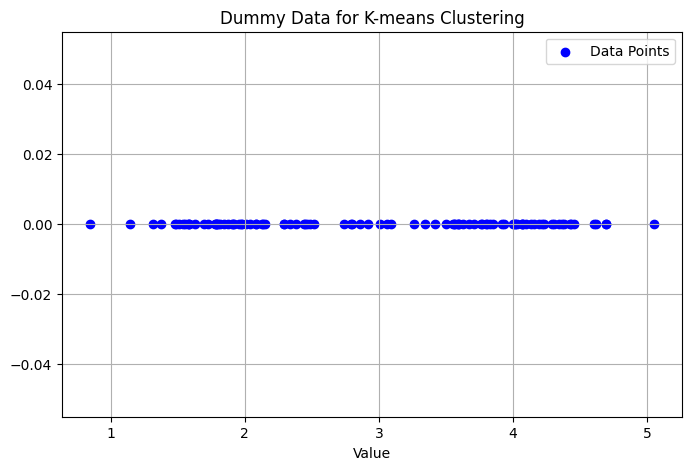

In [150]:
# Number of data points per cluster
num_points_per_cluster = 50

# Mean and standard deviation for each cluster
cluster1_mean = 2
cluster1_std = 0.5

cluster2_mean = 4
cluster2_std = 0.5





# Generate data points for each cluster
cluster1_points = np.random.normal(cluster1_mean, cluster1_std, num_points_per_cluster)
cluster2_points = np.random.normal(cluster2_mean, cluster2_std, num_points_per_cluster)

# Concatenate data points
data = np.concatenate([cluster1_points, cluster2_points]).reshape(-1,1)

# Shuffle data points
np.random.shuffle(data)

# Plot the data
plt.figure(figsize=(8, 5))
plt.scatter(data, np.zeros_like(data), color='blue', label='Data Points')
plt.xlabel('Value')
plt.title('Dummy Data for K-means Clustering')
plt.legend()
plt.grid(True)
plt.show()



### 3 K-means algorithm

The K-means algorithm is a method to automatically cluster similar data examples together. Concretely, you are given a training set $\{x^{(1)} , \cdots, x^{(m)}\}$ (where $x^{(i)} \in \mathbb{R}^n$), and want to group the data into a few cohesive “clusters”. The intuition behind K-means is an iterative procedure that starts by guessing the initial centroids, and then refines this guess by repeatedly assigning examples to their closest centroids and then recomputing the centroids based on the assignments.

The K-means algorithm is as follows:

```python
centroids = kMeansInitCentroids(X, K)
for i in range(iterations):
    # Cluster assignment step: Assign each data point to the
    # closest centroid. idx[i] corresponds to cˆ(i), the index
    # of the centroid assigned to example i
    idx = findClosestCentroids(X, centroids)
    
    # Move centroid step: Compute means based on centroid
    # assignments
    centroids = computeMeans(X, idx, K)
```

The inner-loop of the algorithm repeatedly carries out two steps: (1) Assigning each training example $x^{(i)}$ to its closest centroid, and (2) Recomputing the mean of each centroid using the points assigned to it. The K-means algorithm will always converge to some final set of means for the centroids. Note that the converged solution may not always be ideal and depends on the initial setting of the centroids. Therefore, in practice the K-means algorithm is usually run a few times with different random initializations. One way to choose between these different solutions from different random initializations is to choose the one with the lowest cost function value (distortion). the two phases of the K-means algorithm are implemented separately in the next sections.

<a id="section1"></a>
#### 3.1.1 Finding closest centroids

In the "cluster assignment" phase of the Quantum K-means algorithm, each training example $x^{(i)}$ is assigned to its closest centroid, determined by the current centroid positions. Specifically, for every example $i$, we encode the data $x$ and the centroids into quantum states. Subsequently, we compute the fidelity between the evolved quantum state of the data point $x^{(i)}$ and all the evolved centroids using the following equation:
$$
F(|\psi_1\rangle, |\psi_2\rangle) = \left| \langle \psi_1 | \psi_2 \rangle \right|^2,
$$
where $|\psi_1\rangle$ represents the quantum state of the data point and $|\psi_2\rangle$ represents the quantum state of a centroid. Each data point is then assigned to the centroid with the highest fidelity.



The code defines three functions for quantum state manipulation and fidelity calculation. The init_state() function initializes a quantum state representing a qubit in the |0⟩ state. The encode_data(x) function encodes classical data into a quantum state by applying a rotation gate with an angle specified by the input parameter x, which is given in radians. It first initializes the quantum state using init_state(), then applies a rotation gate to it. The calculate_fid(state1, state2) function calculates the fidelity between two quantum states represented as column vectors.

In [151]:
def init_state():
    """
    Initialize a quantum state representing a qubit in the |0⟩ state.

    Returns:
    numpy.ndarray: A column vector representing the |0⟩ state in the computational basis.
    """
    return np.array([[1], [0]])


def encode_data(x):
    """
    Encode classical data into a quantum state by applying a rotation gate.

    Args:
    x (float): The angle in radians by which to rotate the qubit state.

    Returns:
    numpy.ndarray: The quantum state after encoding the data, obtained by applying a rotation gate.
    """
    state = init_state()  # Initialize the quantum state
    rx = RYGate(float(x)).to_matrix()  # Create a rotation gate with the given angle
    evolved_state = rx @ state  # Apply the rotation gate to the initial state
    
    return evolved_state


def calculate_fid(state1, state2):
    """
    Calculate the fidelity abs(inner product)^2 between two quantum states.

    Args:
    state1 (numpy.ndarray): The first quantum state represented as a column vector.
    state2 (numpy.ndarray): The second quantum state represented as a column vector.

    Returns:
    float: The fidelity between the two quantum states.
    """
    return np.abs(np.dot(state1.conj().transpose(), state2))**2


The provided findClosestCentroids function computes the centroid memberships for every example in a dataset X by calculating the fidelity between each data point and each centroid in the provided centroid array. It initializes a fidelity matrix with zeros, where each row corresponds to a data point and each column corresponds to a centroid. Then, it iterates over each data point and each centroid, calculating the fidelity between them using the calculate_fid function. Finally, it assigns each data point to the centroid with the highest fidelity and returns a vector idx containing the indices of the closest centroids for each data point in the dataset X. 

In [152]:
def findClosestCentroids(X, centroids):
    """
    Compute the closest centroid for each example in a dataset.
    
    Parameters
    ----------
    X : array_like
        The dataset of size (m, n) where each row is a single example. 
        That is, there are m examples each of n dimensions.
        
    centroids : array_like
        The centroids of size (K, n) for K clusters, each with n dimensions.
    
    Returns
    -------
    idx : numpy.ndarray
        A vector of size (m, ) where each element represents the index of the closest centroid
        for the corresponding example in the dataset X.
    
    Description
    -----------
    This function computes the closest centroid for each example in the dataset X. It iterates over
    each example and calculates the fidelity between the example and each centroid using the 
    calculate_fid function. Then, it assigns each example to the centroid with the highest fidelity.
    The resulting indices of the closest centroids are stored in the idx vector and returned.
    """
    fidelity = np.zeros((X.shape[0], centroids.shape[0]))

    # Calculate fidelity between each example and centroid
    for i in range(X.shape[0]):
        for k in range(centroids.shape[0]):     
            fidelity[i, k] = calculate_fid(encode_data(X[i][0]), encode_data(centroids[k][0]))

    # Find the index of the centroid with the highest fidelity for each example
    idx =  fidelity.argmax(axis=1) 

    return idx



This code segment initializes K-means clustering with two centroids specified as [0] and [7]. The variable K indicates the number of centroids, set to 2 in this case. Then, it calls the findClosestCentroids function to determine the closest centroid for each data point in the dataset X using the initial centroids provided. The resulting centroid assignments are stored in the vector idx. Finally, it prints the centroid assignments for the first three examples in the dataset X to verify the clustering process.

In [153]:
# Select an initial set of centroids
X =data
K = 2   # 3 Centroids
initial_centroids = np.array([[0], [7]])

# Find the closest centroids for the examples using the initial_centroids
idx = findClosestCentroids(X, initial_centroids)

print('Closest centroids for the first 3 examples:')
print(idx[:3])


Closest centroids for the first 3 examples:
[0 1 0]


C:\Users\Omar\AppData\Local\Temp\ipykernel_5460\1582761814.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fidelity[i, k] = calculate_fid(encode_data(X[i][0]), encode_data(centroids[k][0]))


<a id="section2"></a>
### 3.1.2 Computing centroid means

Given assignments of every point to a centroid, the second phase of the algorithm recomputes, for each centroid, the mean of the points that were assigned to it. Specifically, for every centroid $k$ we set

$$ \mu_k := \frac{1}{\left| C_k\right|} \sum_{i \in C_k} x^{(i)}$$

where $C_k$ is the set of examples that are assigned to centroid $k$. Concretely, if two examples say $x^{(3)}$ and $x^{(5)}$ are assigned to centroid $k = 2$, then you should update $\mu_2 = \frac{1}{2} \left( x^{(3)} + x^{(5)} \right)$.



This function computeCentroids computes the centroids for K clusters based on the current centroid assignments. It takes three parameters: X, the dataset of size (m, n) where each row is a single example; idx, a vector of size (m,) where each element represents the index of the closest centroid for the corresponding example in the dataset X; and K, the number of clusters. The function initializes an array centroids to store the centroid coordinates, with each centroid having the same number of dimensions as the examples in the dataset X. Then, it iterates over each cluster, calculates the mean of the data points assigned to that cluster using np.average, and assigns the mean as the centroid coordinates for that cluster. Finally, it returns the resulting centroids.

In [154]:
def computeCentroids(X, idx, K):
    """
    Compute the centroids for K clusters based on the current centroid assignments.
    
    Parameters
    ----------
    X : array_like
        The dataset of size (m, n) where each row is a single example. 
        That is, there are m examples each of n dimensions.
    
    idx : array_like
        A vector of size (m, ) where each element represents the index of the closest centroid
        for the corresponding example in the dataset X.
        
    K : int
        The number of clusters.
    
    Returns
    -------
    centroids : numpy.ndarray
        An array of size (K, n) containing the centroids for each cluster.
    
    Description
    -----------
    This function computes the centroids for K clusters based on the current centroid assignments.
    It initializes an array `centroids` to store the centroid coordinates, with each centroid having
    the same number of dimensions as the examples in the dataset X. Then, it iterates over each cluster,
    calculates the mean of the data points assigned to that cluster, and assigns the mean as the centroid
    coordinates for that cluster. The resulting centroids are returned.
    """
    centroids = np.zeros((K, X.shape[1]))
    
    # Compute centroids for each cluster
    for i in range(K):
        centroids[i, :] = np.average(X[idx == i], axis=0)
        
    return centroids


In [155]:
# Compute means based on the closest centroids found in the previous part.
centroids = computeCentroids(X, idx, K)

print('Centroids computed after initial finding of closest centroids:')
print(centroids)


Centroids computed after initial finding of closest centroids:
[[4.05904047]
 [2.10235563]]


### 3.2 Random initialization 

The initial assignments of centroids for the example dataset in the previous cells were chosen manually but, In practice, a
good strategy for initializing the centroids is to select random examples from the training set.



The function kMeansInitCentroids initializes K centroids to be used in K-means clustering on the dataset X. It takes two parameters: X, the dataset of size (m x n), and K, the number of clusters. The function randomly selects K distinct data points from the dataset X as initial centroids using np.random.choice() with the parameter replace=False to ensure that each selected centroid is unique. These randomly selected data points become the initial centroids for the K-means algorithm. The function then returns these centroids as a matrix of size (K x n), where each row represents the coordinates of a centroid in the dataset's feature space. 

In [156]:
def kMeansInitCentroids(X, K):
    """
    This function initializes K centroids that are to be used in K-means on the dataset x.
    
    Parameters
    ----------
    X : array_like 
        The dataset of size (m x n).
    
    K : int
        The number of clusters.
    
    Returns
    -------
    centroids : array_like
        Centroids of the clusters. This is a matrix of size (K x n).
    """
    random_indices = np.random.choice(X.shape[0], size=K, replace=False)

    centroids =X[random_indices, :]

    return centroids

The kMeansInitCentroids Function is applied on dataset X with number of clusters K in the code below.

In [157]:
kMeansInitCentroids(X, K)

array([[3.06005005],
       [4.62187308]])


Finally the function k_means performs K-means clustering on a given dataset X. It initializes centroids using the kMeansInitCentroids function, then iteratively assigns examples to the nearest centroids and updates the centroids until convergence using the findClosestCentroids and computeCentroids functions, respectively. This process is repeated for a maximum of 100 iterations to ensure convergence. After each iteration, the silhouette score, a measure of clustering quality, is calculated using the silhouette_score function from scikit-learn. The final centroids, centroid assignments, and silhouette score with the highest value across all iterations are returned

In [158]:
def k_means(X, K):
    """
    Perform K-means clustering on the dataset X.

    Parameters
    ----------
    X : array_like 
        The dataset of size (m x n).

    K : int
        The number of clusters.

    Returns
    -------
    centroids_final : array_like
        The final centroids after K-means clustering. This is a matrix of size (K x n).

    idx_final : array_like
        The final centroid assignments for each example in the dataset X. This is a vector of size (m, ).

    sil_score : float
        The silhouette score, a measure of clustering quality. Higher values indicate better clustering.

    Description
    -----------
    This function performs K-means clustering on the dataset X. It initializes centroids using the
    `kMeansInitCentroids` function, then iteratively assigns examples to the nearest centroids and 
    updates the centroids until convergence using the `findClosestCentroids` and `computeCentroids` 
    functions, respectively. The process is repeated for a maximum of 100 iterations. After each 
    iteration, the silhouette score is calculated using the `silhouette_score` function from scikit-learn.
    The final centroids, centroid assignments, and silhouette score with the highest value across all 
    iterations are returned.
    """
    idx_final = np.zeros((X.shape[0], 1))
    sil_score = -1
    centroids_final = np.zeros((K, X.shape[1]))
    
    # Repeat the K-means algorithm for a maximum of 100 iterations
    for j in range(100):
        centroids = kMeansInitCentroids(X, K)
        
        # Iterate until convergence
        for i in range(100):
            idx = findClosestCentroids(X, centroids)
            centroids = computeCentroids(X, idx, K)
        
        # Calculate silhouette score
        sil_score_curr = silhouette_score(X, idx)
        
        # Update final centroids, centroid assignments, and silhouette score if silhouette score improves
        if sil_score_curr > sil_score:
            sil_score = sil_score_curr
            idx_final = idx
            centroids_final = centroids

    return centroids_final, idx_final, sil_score


The k_means function was applied to the dataset X with a specified number of clusters K=2. It returned three outputs: centroidsComputed, cluster_idx, and sil_score, representing the final centroids after K-means clustering, the final centroid assignments for each example in the dataset X, and the silhouette score indicating the clustering quality, respectively. 

In [159]:
centroidsComputed,cluster_idx,sil_score=k_means(X,2)


C:\Users\Omar\AppData\Local\Temp\ipykernel_5460\1582761814.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fidelity[i, k] = calculate_fid(encode_data(X[i][0]), encode_data(centroids[k][0]))
C:\Users\Omar\AppData\Local\Temp\ipykernel_5460\1582761814.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fidelity[i, k] = calculate_fid(encode_data(X[i][0]), encode_data(centroids[k][0]))
C:\Users\Omar\AppData\Local\Temp\ipykernel_5460\1582761814.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this opera

In [160]:
cluster_idx=cluster_idx.reshape(-1,1) # index of each X data point given
cluster_idx

array([[0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
    

In [161]:
centroidsComputed # the centroids resulting from the K-means algorithm

array([[3.95560279],
       [1.97099112]])

In [162]:
sil_score # the shiliotte score of this clustering 

0.7135036458005051

### 4 Cluster Visualization


Finally The code segment below visualizes the example data points with colors corresponding to their labels. It begins by defining labels, which represent the cluster assignments for each data point in the dataset X. Additionally, it defines label_colors as a dictionary mapping each label to a specific color. Next, it creates a scatter plot where each data point's x-coordinate is taken from the first column of X, and the color is determined by the corresponding label using the label_colors dictionary.

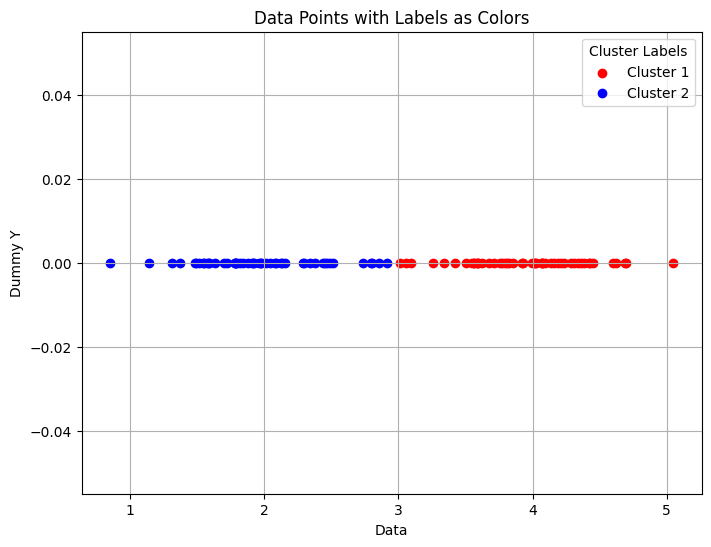

In [183]:
# Example data

labels =cluster_idx # Example labels, corresponding to each data point in X

label_colors = {0: 'red', 1: 'blue', 2: 'green', 3:'orange'}  # Add more colors as needed

# Plot the data points with colors corresponding to their labels
plt.figure(figsize=(8, 6))

# Plot the data points for Cluster 1
plt.scatter(X[cluster_idx == 0], np.zeros_like(X[cluster_idx == 0]), color=label_colors[0], label='Cluster 1')

# Plot the data points for Cluster 2
plt.scatter(X[cluster_idx == 1], np.zeros_like(X[cluster_idx == 1]), color=label_colors[1], label='Cluster 2')


plt.title('Data Points with Labels as Colors')
plt.xlabel('Data')
plt.ylabel('Dummy Y')
plt.legend(title='Cluster Labels')
plt.grid(True)
plt.show()